In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, make_scorer

sys.path.append("..")
from src import utility
from src import preprocessing
from src import features_engineering

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [26]:
# Read the data from the csv file
data = pd.read_csv(r'data\paris_temperature.csv')
data.head(2)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Paris,France",2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,...,3.5,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,"Paris,France",2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,...,4.4,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              382 non-null    object 
 1   datetime          382 non-null    object 
 2   tempmax           382 non-null    float64
 3   tempmin           382 non-null    float64
 4   temp              382 non-null    float64
 5   feelslikemax      382 non-null    float64
 6   feelslikemin      382 non-null    float64
 7   feelslike         382 non-null    float64
 8   dew               382 non-null    float64
 9   humidity          382 non-null    float64
 10  precip            382 non-null    float64
 11  precipprob        382 non-null    float64
 12  precipcover       382 non-null    float64
 13  preciptype        308 non-null    object 
 14  snow              382 non-null    float64
 15  snowdepth         382 non-null    float64
 16  windgust          382 non-null    float64
 1

# **Features Explanation**

The dataset contains **33 columns (features)** related to weather data in Paris. Below is a detailed explanation of each column, including their meanings and typical values:

### **1. General Information Columns**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `name`           | Location name                                    | `"Paris, France"`             |
| `datetime`       | Date of observation                             | `"2023-10-01"` (YYYY-MM-DD)   |

---

### **2. Temperature-Related Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `tempmax`        | Maximum daily temperature (°C)                   | `26.5`                         |
| `tempmin`        | Minimum daily temperature (°C)                   | `12.5`                         |
| `temp`           | Average daily temperature (°C)                   | `18.9`                         |
| `feelslikemax`   | Maximum daily **feels-like** temperature (°C)    | `26.5`                         |
| `feelslikemin`   | Minimum daily **feels-like** temperature (°C)    | `12.5`                         |
| `feelslike`      | Average daily **feels-like** temperature (°C)    | `18.9`                         |

👉 *"Feels-like temperature"* is the temperature perceived by humans, considering humidity and wind.

---

### **3. Humidity & Precipitation Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `dew`            | Dew point temperature (°C)                      | `13.7`                         |
| `humidity`       | Relative humidity (%)                           | `74.3`                         |
| `precip`         | Total precipitation (rain/snow) (mm)            | `0.5`                          |
| `precipprob`     | Probability of precipitation (%)                | `30` (means 30% chance of rain) |
| `precipcover`    | Fraction of the day with precipitation (0–1)    | `0.4` (means 40% of the day had precipitation) |
| `preciptype`     | Type of precipitation                           | `"rain"`, `"snow"`, `"none"`   |
| `snow`           | Snowfall (mm)                                   | `0.0` (if no snow)             |
| `snowdepth`      | Snow depth (mm)                                 | `0.0` (if no snow on ground)   |

---

### **4. Wind & Pressure Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `windgust`       | Wind gust speed (km/h)                          | `30.2`                         |
| `windspeed`      | Average wind speed (km/h)                       | `12.3`                         |
| `winddir`        | Wind direction (degrees)                        | `180` (south wind)             |
| `sealevelpressure` | Atmospheric pressure at sea level (hPa)      | `1015.2`                        |

---

### **5. Visibility & Cloud Cover Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `cloudcover`     | Cloud cover (%)                                 | `60` (60% of sky covered by clouds) |
| `visibility`     | Visibility distance (km)                        | `10` (10 km visibility)        |

---

### **6. Solar & UV Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `solarradiation` | Solar radiation (W/m²)                          | `250`                          |
| `solarenergy`    | Solar energy received (MJ/m²)                   | `4.2`                          |
| `uvindex`        | UV Index (intensity of UV radiation)             | `3` (moderate UV level)        |

---

### **7. Additional Risk & Astronomy Features**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `severerisk`     | Risk level for severe weather (0-10)            | `2` (low risk)                 |
| `sunrise`        | Time of sunrise (UTC)                           | `"2023-10-01T07:49:34"`        |
| `sunset`         | Time of sunset (UTC)                            | `"2023-10-01T19:30:27"`        |
| `moonphase`      | **Moon phase (0 to 1)**                         | `0.57`                         |

#### **🔹 What is `moonphase`?**
- `moonphase` represents the phase of the moon **as a fraction between 0 and 1**:
  - `0.00` = New Moon 🌑
  - `0.25` = First Quarter 🌓
  - `0.50` = Full Moon 🌕
  - `0.75` = Last Quarter 🌗
  - `1.00` = New Moon (cycle repeats)

---

### **8. Weather Descriptions**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `conditions`     | General weather conditions                      | `"Rain, Partially cloudy"`     |
| `description`    | More detailed weather description                | `"Partly cloudy throughout the day with morning rain."` |
| `icon`          | Icon representing weather                        | `"rain"`, `"clear-day"`, `"snow"` |

---

### **9. Station Data**
| **Feature**       | **Meaning**                                        | **Example Values**              |
|------------------|-------------------------------------------------|--------------------------------|
| `stations`       | Weather stations used for this data point        | `"07149099999, 07156099999"`  |

---

### **Summary**
- The dataset contains **weather measurements, precipitation, wind, solar data, and astronomical info**.
- The `moonphase` feature **ranges from 0 to 1**, indicating different moon phases.
- Other features like `temp`, `humidity`, and `windspeed` provide essential weather insights.

# **Exploratory Data Analyst**

In [28]:
# Check the duplicate data
d = data.shape[0] - data.duplicated().shape[0]
print(f'The number of duplicate data: {d}')

The number of duplicate data: 0


Number of columns with NaN values: 2


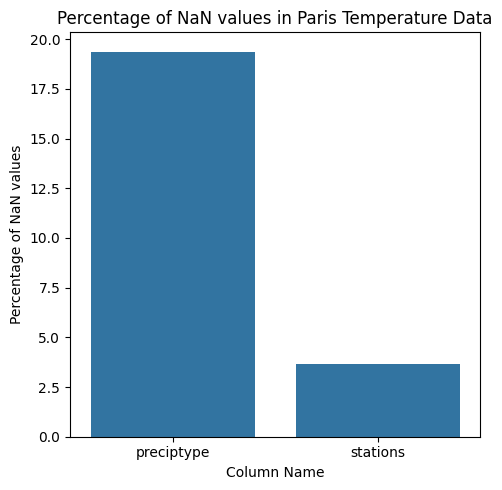

In [29]:
# Run missing value analysis
df_nan = utility.nan_df_create(data)
utility.plot_nan_percent(df_nan, "Paris Temperature Data", figsize=(5, 5), rotation=0)

In [30]:
# Identify numerical and categorical features
numerical_features = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = data.drop(columns=["datetime","name","sunrise","sunset"]).select_dtypes(include=["object"]).columns.tolist()

### Numberical Features

In [31]:
data[numerical_features].describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,16.802356,10.096859,13.279319,16.541623,8.974869,12.624346,8.784293,76.118586,2.053552,71.432461,...,18.495550,209.079843,1013.928796,79.876178,19.180628,49.813874,4.296335,2.913613,10.746073,0.481990
std,6.840083,5.057506,5.819955,7.388110,6.197290,6.674208,4.779705,10.214621,3.939574,44.425978,...,6.069653,87.970190,10.349025,19.049478,4.334291,37.130885,3.214728,2.267046,5.473000,0.289633
min,-1.300000,-4.100000,-1.800000,-5.500000,-7.300000,-6.300000,-6.100000,51.600000,0.000000,0.000000,...,6.800000,0.400000,979.700000,13.000000,5.100000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,11.800000,6.625000,9.300000,11.800000,4.600000,8.025000,6.200000,68.600000,0.000000,0.000000,...,13.900000,180.750000,1008.900000,71.200000,16.800000,16.825000,1.400000,1.000000,10.000000,0.242500
50%,16.150000,10.200000,13.050000,16.150000,10.200000,13.050000,9.150000,76.750000,0.195000,100.000000,...,17.850000,222.000000,1014.650000,85.600000,20.300000,43.500000,3.800000,2.000000,10.000000,0.480000
75%,21.850000,13.600000,17.575000,21.850000,13.600000,17.575000,12.175000,84.475000,2.143000,100.000000,...,21.975000,265.675000,1019.900000,94.075000,22.100000,76.325000,6.500000,4.000000,10.000000,0.750000
max,36.200000,21.200000,28.300000,39.000000,21.200000,29.600000,20.300000,95.000000,25.008000,100.000000,...,44.300000,358.200000,1042.800000,100.000000,39.100000,169.800000,14.700000,8.000000,75.000000,0.980000


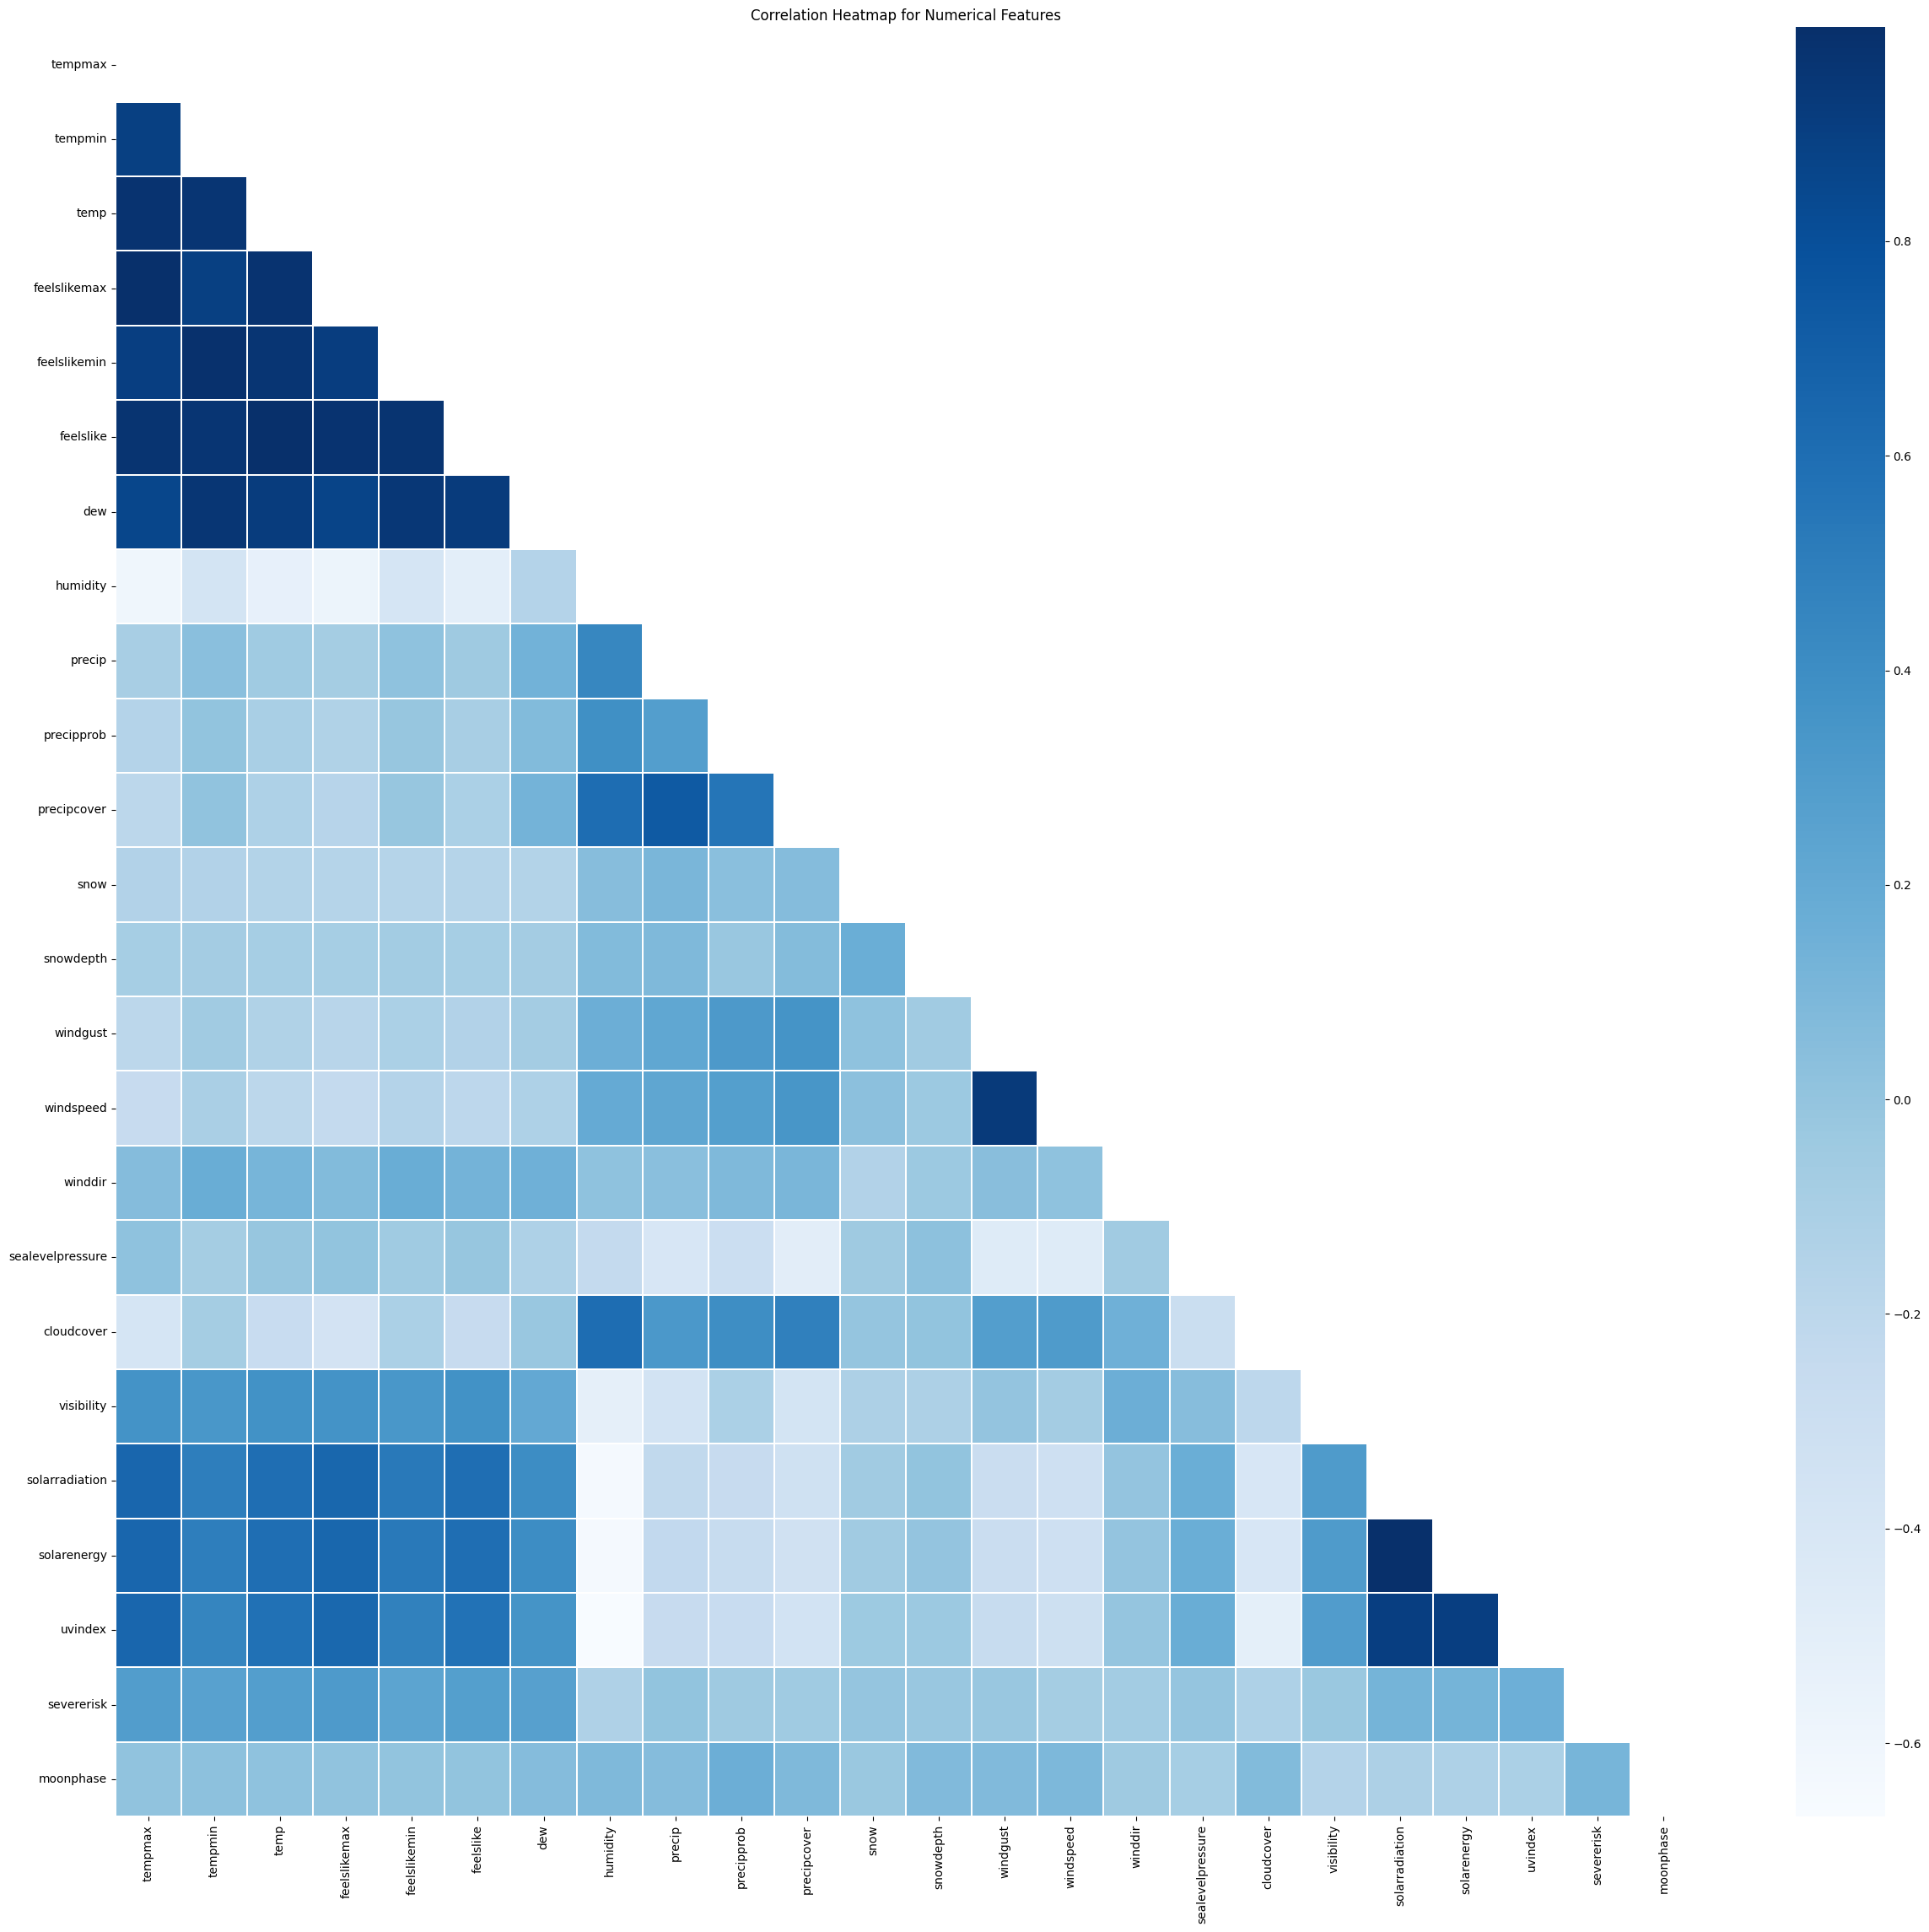

In [32]:
# Run correlation matrix
corr_matrix = utility.correlation_matrix(data, columns_to_drop=["datetime"])
corr_matrix.plot_correlation_matrix()

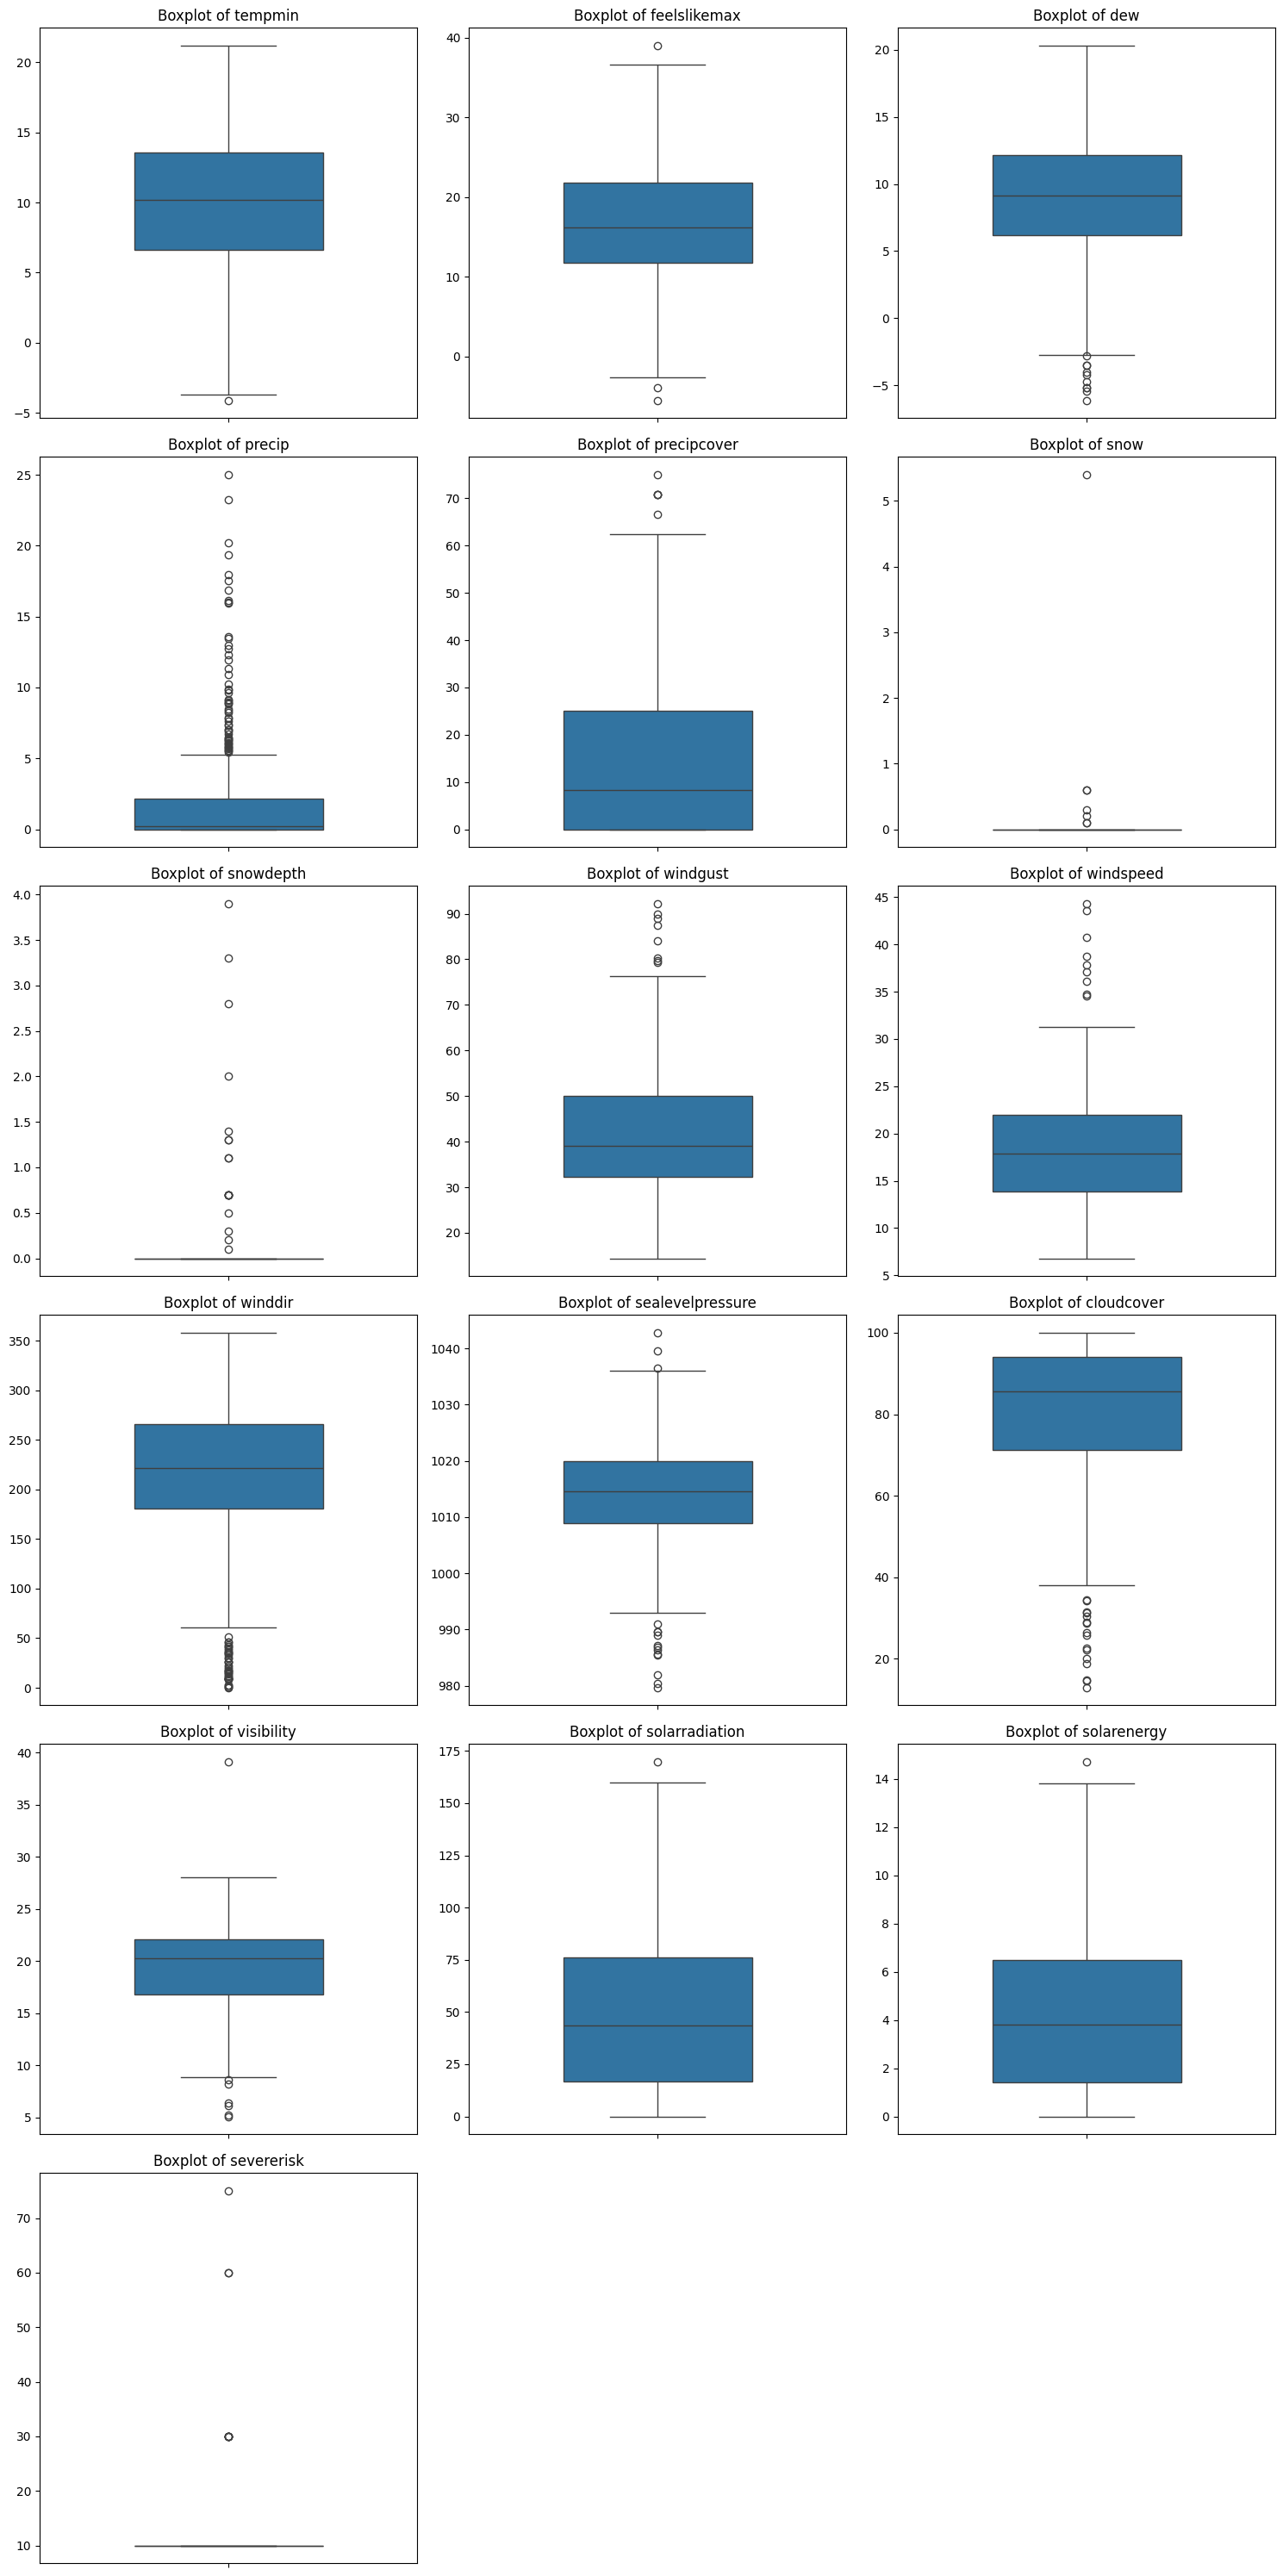

In [33]:
# Run outlier detection
utility.plot_outlier_boxplots(data, numerical_features)

### Categorical Features

In [34]:
cate_df = data[['preciptype','conditions','description','icon']]

In [35]:
cate_df

,preciptype,conditions,description,icon
0,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain
1,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain
3,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain
4,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain
...,...,...,...,...
377,rain,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain
378,rain,Overcast,Cloudy skies throughout the day.,cloudy
379,rain,Overcast,Cloudy skies throughout the day.,cloudy
380,rain,Overcast,Cloudy skies throughout the day.,cloudy


In [36]:
cate_df[cate_df.isnull().any(axis=1)]

,preciptype,conditions,description,icon
1,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
6,NaN,Clear,Clear conditions throughout the day.,clear-day
8,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
9,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
15,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
...,...,...,...,...
345,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
353,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
364,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
369,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [37]:
data["preciptype"].value_counts()

preciptype
rain                      301
rain,snow                   6
rain,freezingrain,snow      1
Name: count, dtype: int64

In [38]:
data[categorical_features].describe()

,preciptype,conditions,description,icon,stations
count,308,382,382,382,368
unique,3,8,31,5,27
top,rain,"Rain, Partially cloudy",Partly cloudy throughout the day.,rain,"07149099999,07156099999,07146099999,0715709999..."
freq,301,136,81,269,247


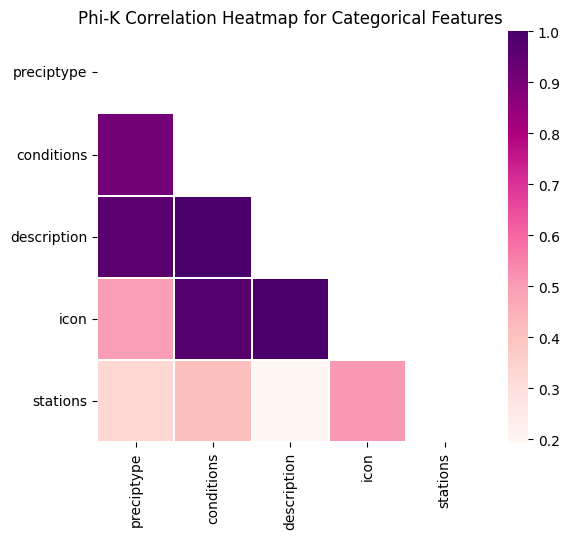

In [39]:
# Run Phi-K correlation analysis
utility.plot_phik_matrix(data, categorical_columns=categorical_features, figsize=(6, 5.5), cmap="RdPu")

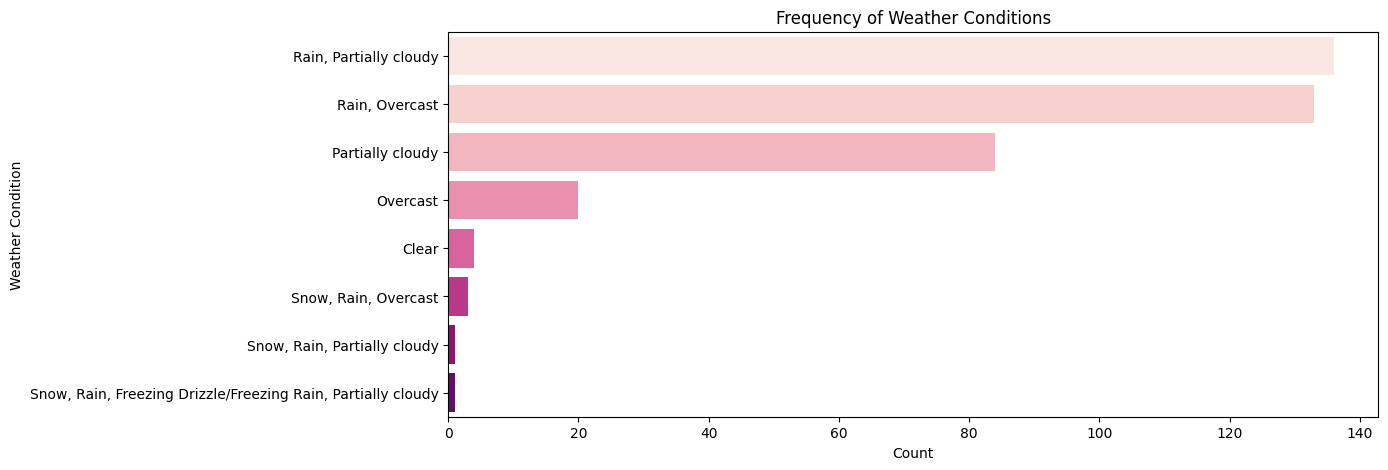

In [40]:
# Categorical Feature Analysis
plt.figure(figsize=(12, 5))
sns.countplot(y=data["conditions"], order=data["conditions"].value_counts().index, palette="RdPu")
plt.title("Frequency of Weather Conditions")
plt.xlabel("Count")
plt.ylabel("Weather Condition")
plt.show()

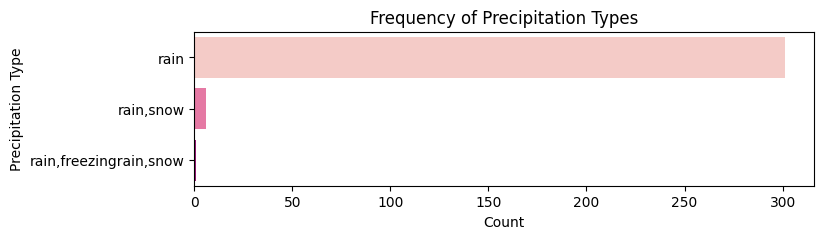

In [41]:
plt.figure(figsize=(8, 2))
sns.countplot(y=data["preciptype"], order=data["preciptype"].value_counts().index, palette="RdPu")
plt.title("Frequency of Precipitation Types")
plt.xlabel("Count")
plt.ylabel("Precipitation Type")
plt.show()

# **Stationality**

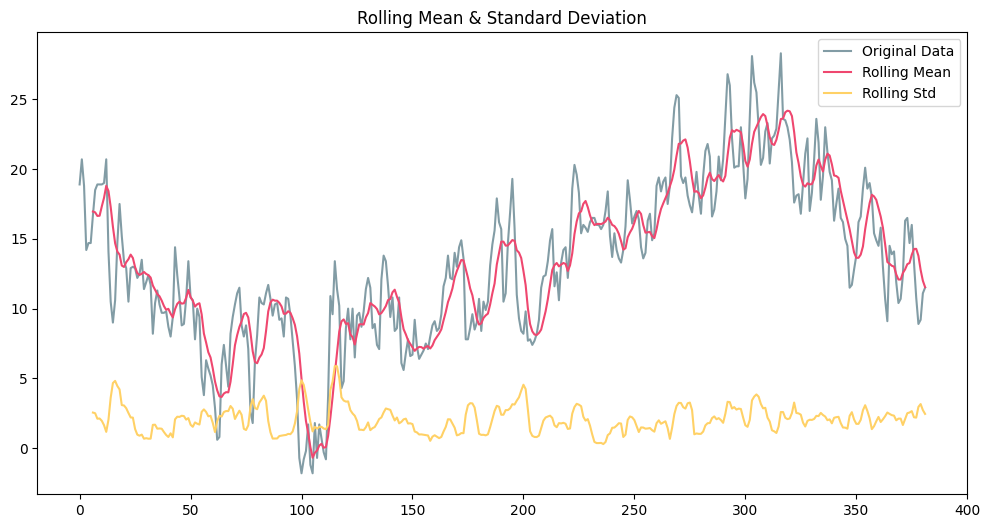

ADF Statistic: -2.74262288763004
p-value: 0.06694856335880939
Critical Values: {'1%': -3.4477686860685, '5%': -2.869216670067509, '10%': -2.570859500573892}
⚠️ Data is not stationary (needs to be processed before forecasting).


In [42]:
utility.check_stationary(data["temp"])

In [43]:
stationary_series, num_diffs, final_adf_results = utility.make_stationary(data['temp'])

print(f"Number of differences: {num_diffs}")
print("-" * 50)
for k, v in final_adf_results.items():
    print(f"{k}: {v}")

Number of differences: 1
--------------------------------------------------
ADF Statistic: -14.794239815296415
p-value: 2.147810770410271e-27
Critical Values: {'1%': -3.4477686860685, '5%': -2.869216670067509, '10%': -2.570859500573892}


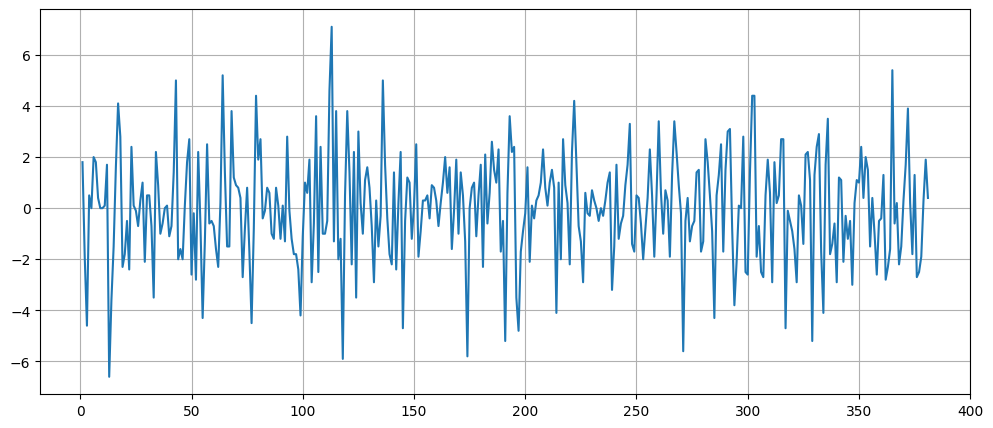

In [44]:
# Plot stationary series over time
plt.figure(figsize=(12, 5))
plt.plot(stationary_series, linestyle='-')
plt.grid(True)
plt.show()

# **Data Preprocessing**

In [45]:
# Convert datetime column to proper datetime format
data['datetime'] = pd.to_datetime(data['datetime'])
data['sunrise'] = pd.to_datetime(data['sunrise'])
data['sunset'] = pd.to_datetime(data['sunset'])

# Sort dataset by datetime
data = data.sort_values(by='datetime')

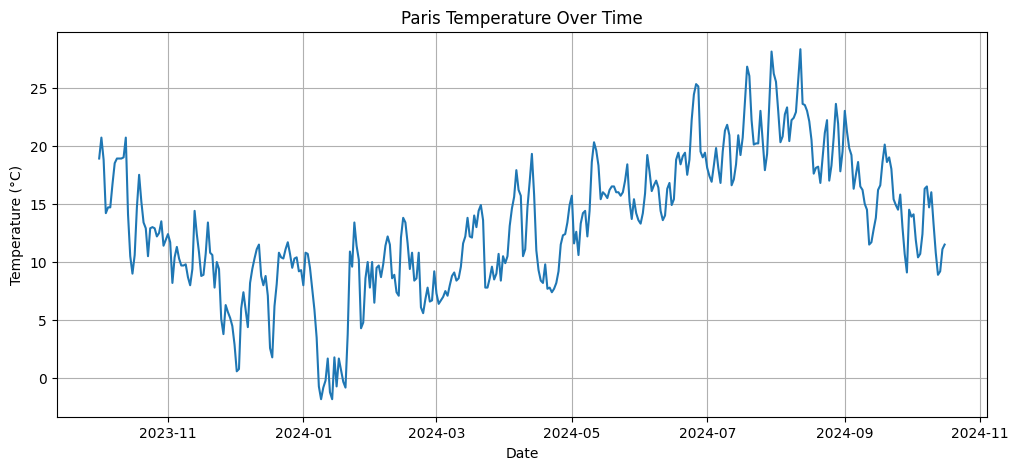

In [46]:
# Plot Paris temperature over time
plt.figure(figsize=(12, 5))
plt.plot(data["datetime"], data["temp"], linestyle='-')
plt.title("Paris Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

In [47]:
# Drop columns with only one unique value
columns_to_drop = [col for col in data.columns if data[col].nunique() == 1]
data = data.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['name']


In [48]:
# Delete columns
data = data.drop(columns=["stations","description","icon",])

### **1. Handling Missing Values**

In [49]:
# Fill null values in "preciptype" with seperator "dry"
data = preprocessing.fill_null_values(data,"preciptype","dry")

### **2. Split Train-Test**

In [50]:
data.to_csv(r"data\data.csv", index=False)

In [51]:
data[data["datetime"] == "2024-09-15"].index

Index([350], dtype='int64')

Train set: 351 rows, from 0 to 350
Test set: 31 rows, from 351 to 381


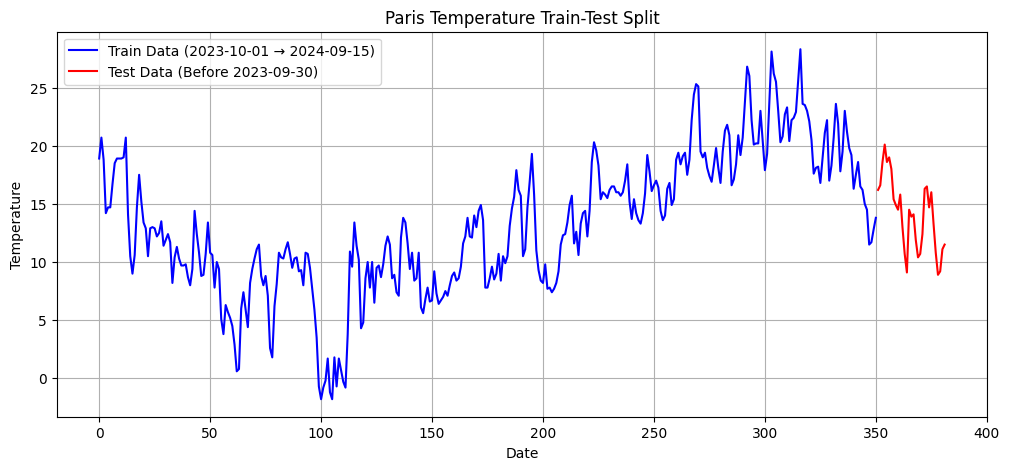

In [52]:
# Train-Test Split
train = data.loc[:350]
test = data.loc[351:]

# Print data sizes
print(f"Train set: {train.shape[0]} rows, from {train.index.min()} to {train.index.max()}")
print(f"Test set: {test.shape[0]} rows, from {test.index.min()} to {test.index.max()}")

# Plot train & test split
plt.figure(figsize=(12,5))
plt.plot(train["temp"], label="Train Data (2023-10-01 → 2024-09-15)", color="blue")
plt.plot(test["temp"], label="Test Data (Before 2023-09-30)", color="red")
plt.legend()
plt.title("Paris Temperature Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.grid(True)
plt.show()


### **3. Handling Outliers**

In [53]:
# Replace outliers using IQR method (capping).
# Replace outliers and Check for outliers before/after
print("#"*20 + "   TRAIN_DATA   " + "#"*20)
print("Before:", preprocessing.count_outliers(train, numerical_features))
train = preprocessing.replace_outliers(train, numerical_features)
print("After:", preprocessing.count_outliers(train, numerical_features))

print("#"*20 + "   TEST_DATA   " + "#"*21)
print("Before:", preprocessing.count_outliers(test, numerical_features))
test = preprocessing.replace_outliers(test, numerical_features)
print("After:", preprocessing.count_outliers(test, numerical_features))

####################   TRAIN_DATA   ####################
Before: {'tempmax': 0, 'tempmin': 2, 'temp': 0, 'feelslikemax': 2, 'feelslikemin': 0, 'feelslike': 0, 'dew': 9, 'humidity': 0, 'precip': 52, 'precipprob': 0, 'precipcover': 5, 'snow': 7, 'snowdepth': 18, 'windgust': 6, 'windspeed': 7, 'winddir': 34, 'sealevelpressure': 19, 'cloudcover': 15, 'visibility': 9, 'solarradiation': 0, 'solarenergy': 0, 'uvindex': 0, 'severerisk': 9, 'moonphase': 0}
After: {'tempmax': 0, 'tempmin': 0, 'temp': 0, 'feelslikemax': 0, 'feelslikemin': 0, 'feelslike': 0, 'dew': 0, 'humidity': 0, 'precip': 0, 'precipprob': 0, 'precipcover': 0, 'snow': 0, 'snowdepth': 0, 'windgust': 0, 'windspeed': 0, 'winddir': 0, 'sealevelpressure': 0, 'cloudcover': 0, 'visibility': 0, 'solarradiation': 0, 'solarenergy': 0, 'uvindex': 0, 'severerisk': 0, 'moonphase': 0}
####################   TEST_DATA   #####################
Before: {'tempmax': 0, 'tempmin': 0, 'temp': 0, 'feelslikemax': 0, 'feelslikemin': 0, 'feelslike': 0, 

### **4. Prophet Model**

In [54]:
# Prepare train data for Prophet
train_prophet = train.reset_index().rename(columns={"datetime": "ds", "temp": "y"})

# Initialize & fit Prophet model
model = Prophet()
model.fit(train_prophet)

10:11:48 - cmdstanpy - INFO - Chain [1] start processing
10:11:49 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
# Create future dataframe
future = model.make_future_dataframe(periods=len(test), freq='D')
# Predict
forecast = model.predict(future)
# Extract predicted values
forecast = forecast[["ds", "yhat"]].set_index("ds")

In [56]:
print(forecast.head(10))

                 yhat
ds                   
2023-10-01  13.166908
2023-10-02  13.744182
2023-10-03  13.613235
2023-10-04  13.618371
2023-10-05  13.854675
2023-10-06  13.503563
2023-10-07  12.651439
2023-10-08  12.653565
2023-10-09  13.230839
2023-10-10  13.099892


In [60]:
# Align test & forecast data
test_forecast = forecast.loc[test["datetime"]]

# Compute Metrics
mse = mean_squared_error(test["temp"], test_forecast.values)
rmse = np.sqrt(mse)
r2 = r2_score(test["temp"], test_forecast)
mape = mean_absolute_percentage_error(test["temp"], test_forecast)

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")
print(f"MAPE: {mape:.2%}")

RMSE: 8.90
R² Score: -7.308
MAPE: 67.30%


# **Feature Engineering**

In [32]:
train.index = train["datetime"]
train = train.drop(columns=["datetime"])

In [33]:
train_data = train.copy()
features_engineering.create_specific_features(train_data)
remove_cols = train_data.columns
numerical_col = train_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
train_data = features_engineering.create_lag_features(train_data, lag=7, columns=numerical_col)
train_data = features_engineering.create_rolling_features(train_data, window=7, columns=["temp"])
train_data = features_engineering.create_rolling_features(train_data, window=14, columns=["temp"])
train_data = features_engineering.create_rolling_features(train_data, window=30, columns=["temp"])

d:\Documents\Text Book\3\Time Series Analytics\Midterm Project\src\features_engineering.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
d:\Documents\Text Book\3\Time Series Analytics\Midterm Project\src\features_engineering.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
d:\Documents\Text Book\3\Time Series Analytics\Midterm Project\src\features_engineering.py:24: PerformanceWarning: DataFrame is highly fragmented.  

In [34]:
y_train = train_data["temp"]
X_train = train_data.drop(columns=remove_cols)

In [35]:
X_train.to_csv(r"data\X_train.csv", index=False)
y_train.to_csv(r"data\y_train.csv", index=False)

In [36]:
test.index = test["datetime"]
test = test.drop(columns=["datetime"])

In [37]:
test_data = test.copy()
features_engineering.create_specific_features(test_data)
numerical_col = test_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
test_data = features_engineering.create_lag_features(test_data, lag=7, columns=numerical_col)
test_data = features_engineering.create_rolling_features(test_data, window=7, columns=["temp"])
test_data = features_engineering.create_rolling_features(test_data, window=14, columns=["temp"])
test_data = features_engineering.create_rolling_features(test_data, window=30, columns=["temp"])

d:\Documents\Text Book\3\Time Series Analytics\Midterm Project\src\features_engineering.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
d:\Documents\Text Book\3\Time Series Analytics\Midterm Project\src\features_engineering.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
d:\Documents\Text Book\3\Time Series Analytics\Midterm Project\src\features_engineering.py:24: PerformanceWarning: DataFrame is highly fragmented.  

In [38]:
y_test = test_data["temp"]
X_test = test_data.drop(columns=remove_cols)

In [39]:
X_test.to_csv(r"data\X_test.csv", index=False)
y_test.to_csv(r"data\y_test.csv", index=False)

# **Feature Selection**

In [2]:
X_train = pd.read_csv(r"data\X_train.csv")
y_train = pd.read_csv(r"data\y_train.csv")

In [3]:
import lightgbm as lgb

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X_train, label=y_train)

# Train a LightGBM model
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": -1
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

In [4]:
# Extract feature importance
feature_importance = lgb_model.feature_importance(importance_type="gain")
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Display the top features
print(feature_importance_df.head(10))

                       Feature    Importance
196           wind_chill_lag_1  40814.972823
0                tempmax_lag_1   8231.779185
308        temp_rolling_mean_7   4333.459415
259      wind_temp_index_lag_1   3010.628306
210  pressure_temp_index_lag_1   1176.575767
21          feelslikemax_lag_1    762.733185
105              winddir_lag_1    680.314506
203    cloud_wind_effect_lag_1    407.370422
28          feelslikemin_lag_1    397.893909
245       dew_temp_index_lag_1    368.525238


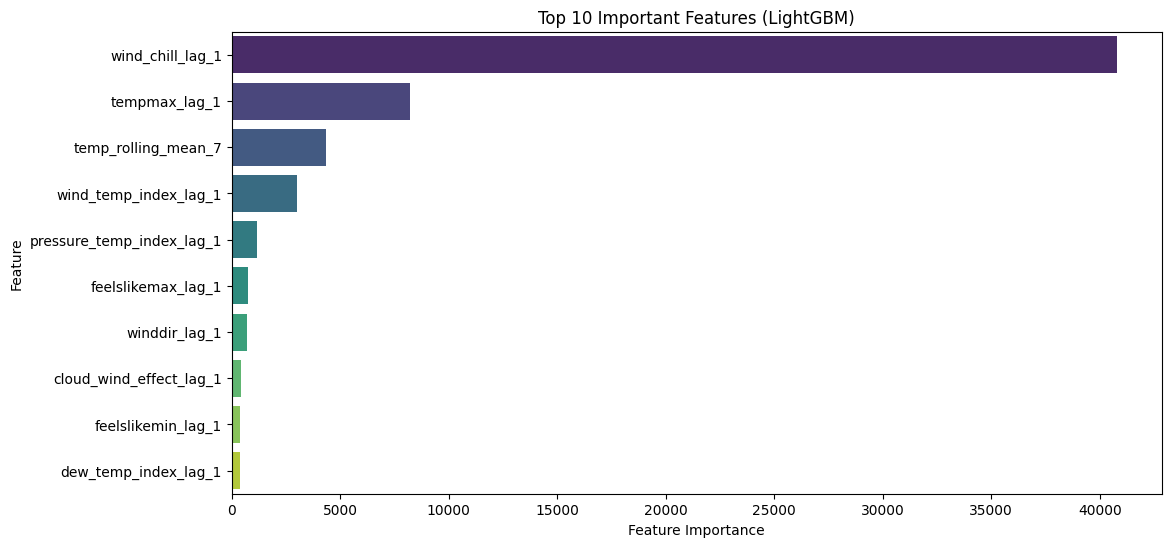

In [5]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Important Features (LightGBM)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

The feature importance is computed using ```importance_type="gain"```. This means that the importance of a feature is measured by the total reduction in **Error** (loss) it contributes when used for splits in decision trees.
- Higher importance → More influential feature, as it helps reduce error the most.

`wind_chill_lag_1` has the highest importance 🡪 This suggests that wind chill from the previous day strongly influences the predicted temperature.

`tempmax_lag_1` is also highly important 🡪 This means that the maximum temperature of the previous day is crucial for predicting the next day’s temperature.

Rolling mean features (`temp_rolling_mean_7`) are significant 🡪 This indicates that long-term temperature trends play a key role in the model’s prediction.

# **Modeling**

### **1. Random Forest**

- In this notebook, we successfully trained and tuned a Random Forest Regressor model to predict temperature data.
- Using RandomizedSearchCV to optimize hyperparameters and achieved a Mean Absolute Error (MAE) of {mae:.2f} °C on the test set.
- The trained model was saved using pickle for future use, and predictions were exported to a CSV file.

[Notebook](https://www.kaggle.com/code/thnquangvinh/rf-modeling/edit)

In [8]:
import joblib
from sklearn.ensemble import RandomForestRegressor

# Open the model file
with open(r"model\random_forest_model.pkl", "rb") as file:
    model = joblib.load(file)

In [ ]:
X_test = pd.read_csv(r"data\X_test.csv")
y_test = pd.read_csv(r"data\y_test.csv")
# Predict using the loaded model
X = pd.read_csv(r"data\data.csv")

y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred,index=range(351,382))

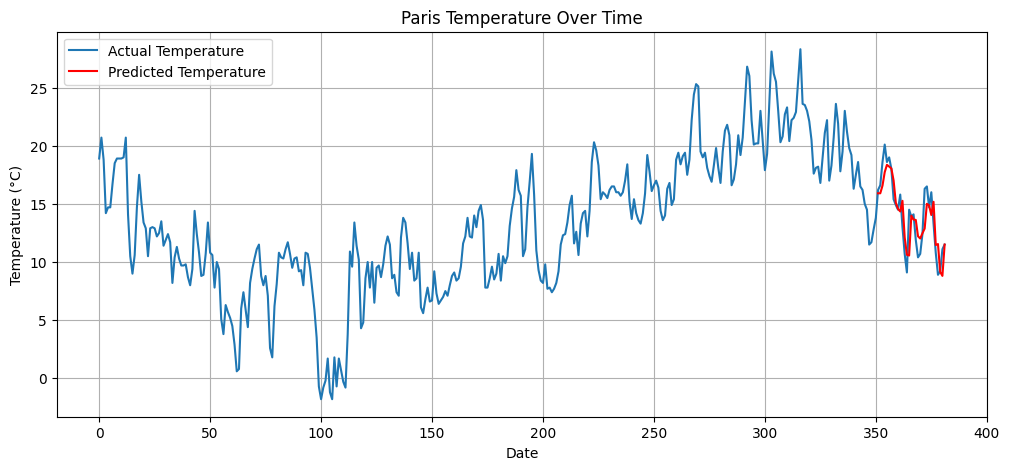

In [16]:
# Plot Paris temperature over time
plt.figure(figsize=(12, 5))
plt.plot(X["temp"], linestyle='-', label="Actual Temperature")
plt.plot(y_pred, linestyle='-', label="Predicted Temperature", color="red")
plt.title("Paris Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluation
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE after tuning: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R² after tuning: {r2:.2f}")

MAE after tuning: 1.26
R² after tuning: 0.72
